Instalacion de Yolo 10 :<br>
Al 31/05/2024 -> YOLO 10 tiene menos de una semana que salió, por lo que se debe instalar desde el repositorio de GitHub.

En una terminal <br>
git clone https://github.com/THU-MIG/yolov10.git <br>
cd yolov10 <br>
pip install . 

In [8]:
from ultralytics import YOLOv10
import pytesseract
import cv2
import supervision as sv
from supervision.draw.color import ColorPalette
from supervision.detection.annotate import BoxAnnotator
import numpy as np

In [9]:
''' 
Entrada: archivo supervision,imagen a recortar

Funcion: Recorta la imagen que se le pase usando los parametros del box de deteccion, en este 
caso se usa la salida de la deteccion de supervision -> sv.Detections.from_ultralytics()

Salida: Imagen recortada 
'''

# funcion que recorta imagenes
def cropped(detections,image):
    bounding_box = detections.xyxy
    # Extraer las coordenadas de la caja delimitadora
    xmin, ymin, xmax, ymax = bounding_box[0]
    # Asegurarse de que las coordenadas sean enteros
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    # Recortar la imagen usando las coordenadas de la caja delimitadora
    cropped_image = image[ymin:ymax, xmin:xmax]
    return cropped_image

# Codigo sobre un frame <br>
El código primero se probará para mayor facilidad sobre un frame y después se utilizará sobre en un video


0: 352x640 1 car, 431.7ms
Speed: 6.0ms preprocess, 431.7ms inference, 4.9ms postprocess per image at shape (1, 3, 352, 640)


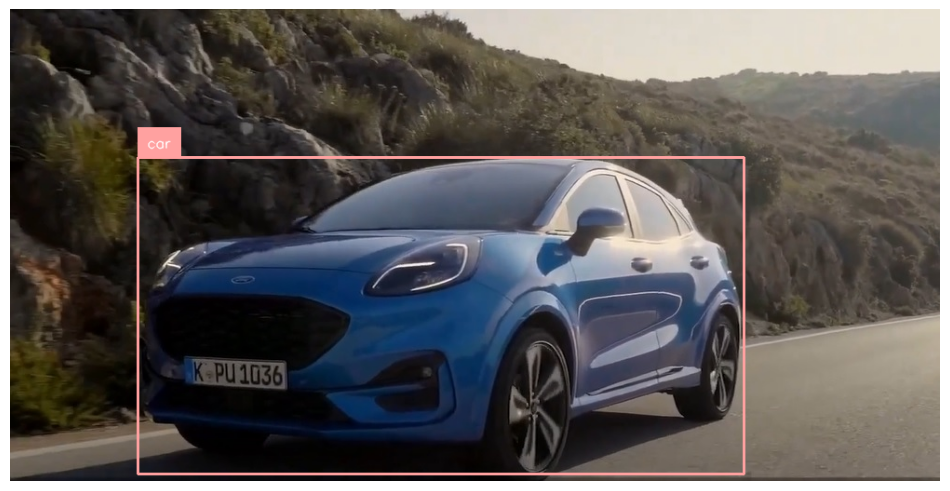

In [10]:
#Deteccion del medio de transporte

#modelo para detectar el medio de transporte
model_t = YOLOv10('models\yolov10n.pt')
#se lee la imagen de un auto 
image_t = cv2.imread('images/auto.jpg')
#se pasa la imagen por el modelo que detecta el medio de transporte
results_t = model_t(image_t)[0]
#se pasan los resultados a la libreria supervison
detections_t = sv.Detections.from_ultralytics(results_t)
# class_ids de interes - autos, motos, buses y camiones
class_id = [2, 3, 5, 7]

#filtra que solo muestre las detecciones de class_id
if detections_t.class_id in class_id:
    #inicializa las etiquetas
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    #Se pasa la informacion que se mostrara en las etiqutes
    annotated_image_t = bounding_box_annotator.annotate(scene=image_t, detections=detections_t)
    annotated_image_t = label_annotator.annotate(scene=annotated_image_t, detections=detections_t)
        
sv.plot_image(annotated_image_t)

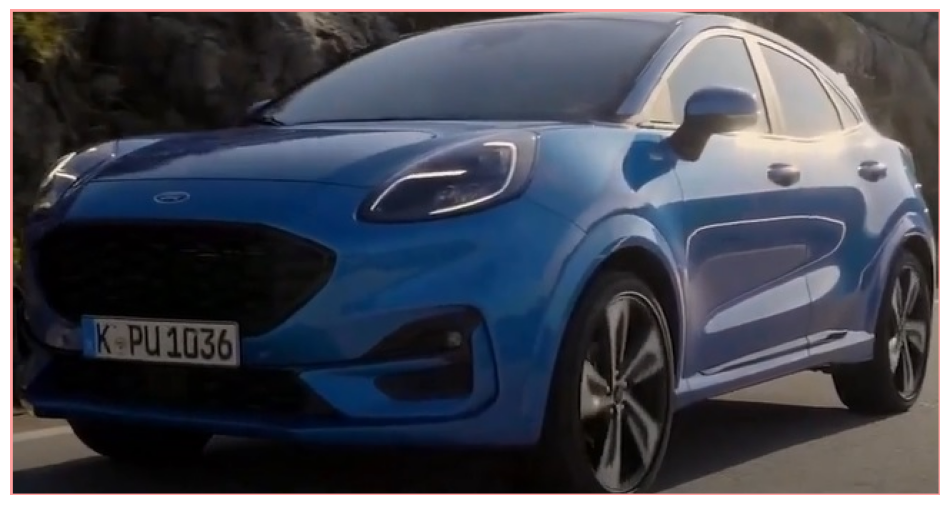

In [11]:
#recorte de imagen de  medio de transporte
cropped_image_t = cropped(detections_t, image_t)
sv.plot_image(cropped_image_t)


0: 352x640 10 pl_license_plates, 362.8ms
Speed: 3.0ms preprocess, 362.8ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


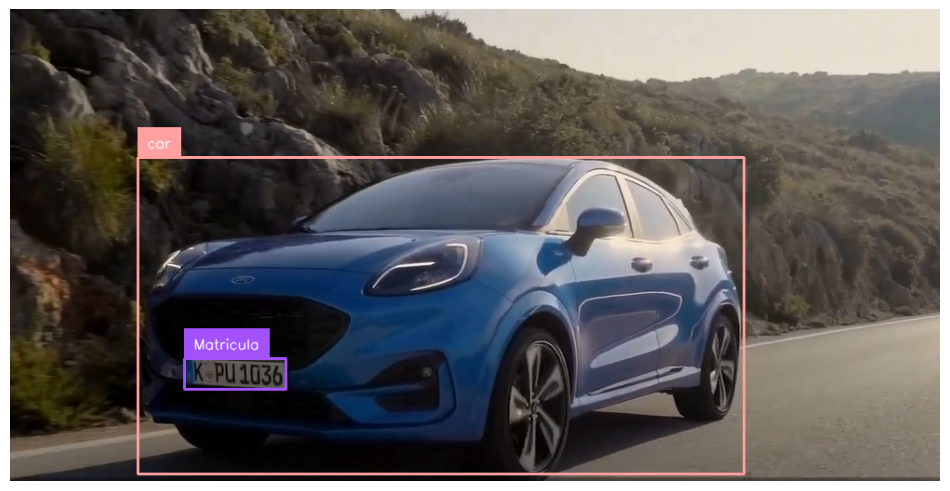

In [12]:
#modelo para detectar el medio de matricula
model_p = YOLOv10('models\placa.pt')
#se pasa la imagen por el modelo que detecta matriculas
results_p = model_p(cropped_image_t, agnostic_nms = True)[0]
#modifica a matricula el nombre que trae por defecto el modelo
results_p.names[0] = "Matricula"
#se pasan los resultados a la libreria supervison
detections_p = sv.Detections.from_ultralytics(results_p)

#Saca la imagen de la matricula antes de cambiar derections_p, 
#se cambia para colocar el box de la matricula
cropped_image_matricula = cropped(detections_p, cropped_image_t)


#PARA PODER PASAR LA COORDENADAS DE LA MATRICULA DE LA IMAGEN RECORTADA DEL AUTO,
# A LA IMAGEN MAS GRANDE 
#diferencia de las coordenadas XY, el largo y ancho de la caja de la matricula
dif_x = results_p.boxes.xyxy[0][2] - results_p.boxes.xyxy[0][0]
dif_y = results_p.boxes.xyxy[0][3] - results_p.boxes.xyxy[0][1]
#Puntos iniciales, suma del punto de deteccion de la placa mas el del medio de transporte
x1_nuevo = detections_t.xyxy[0][0] + detections_p.xyxy[0][0]
y1_nuevo = detections_t.xyxy[0][1] + detections_p.xyxy[0][1] 
#puntos finales, suma del pueto inicial mas las dimensiones de la box de matricula
x2_nuevo = x1_nuevo + dif_x  
y2_nuevo = y1_nuevo + dif_y 
#salvar las nuevas coordenadas 
detections_p.xyxy = np.array([[x1_nuevo,y1_nuevo,x2_nuevo,y2_nuevo]])


#inicializa las etiquetas de matriculas
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
#Se pasa la informacion que se mostrara en las etiqutes
annotated_image_p = bounding_box_annotator.annotate(scene=image_t, detections=detections_p)
annotated_image_p = label_annotator.annotate(scene=annotated_image_p, detections=detections_p)
#transforma el formato de color al formato comun
#annotated_image_p = cv2.cvtColor(annotated_image_p, cv2.COLOR_BGR2RGB)
sv.plot_image(annotated_image_p)


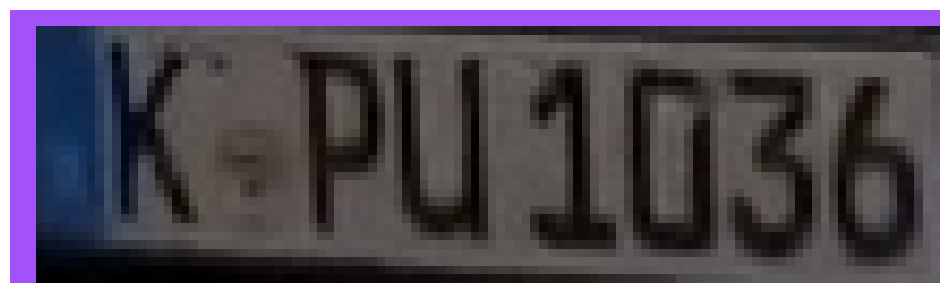

In [13]:
sv.plot_image(cropped_image_matricula)

Matricula Detectada: KPU1036


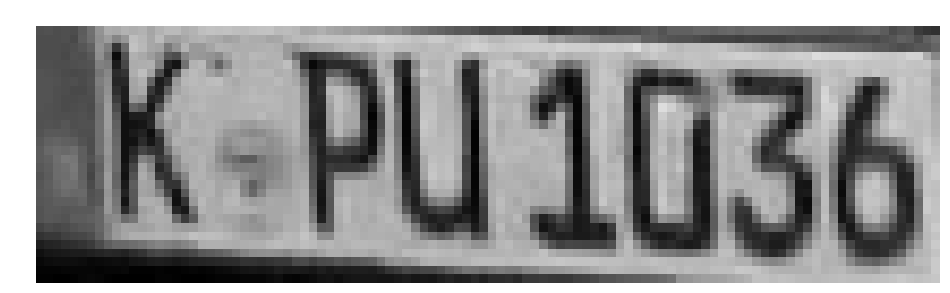

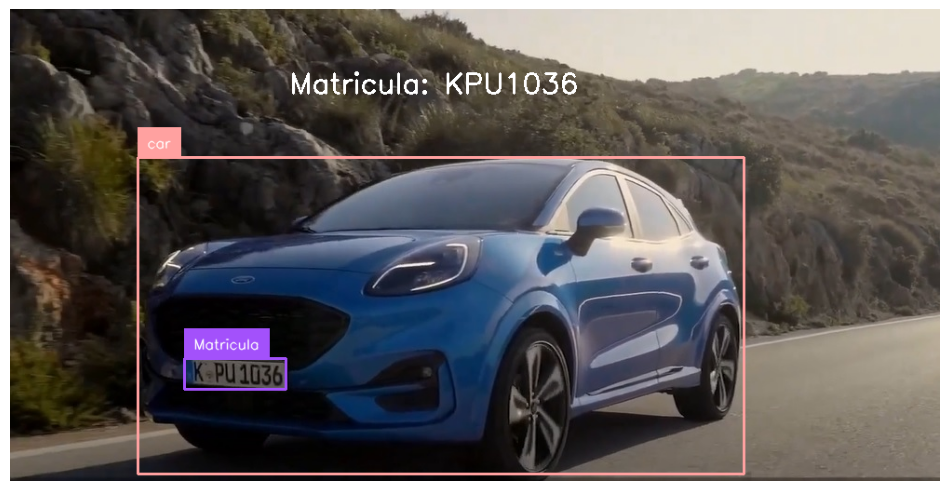

In [14]:
#lectura de la placa con el ocr

#TRANSFORMACIONES DE LA IMAGEN PARA MEJORAR LA LECTURA  DEL OCR

# Cargamos la imagen, y la convertimos a escala de grises.
gray = cv2.cvtColor(cropped_image_matricula, cv2.COLOR_BGR2GRAY)

# Algunas transformaciones de la imagen, para para mejorar la lectura del OCR
# pero no fue necesario, ya que distorcionaba mucho la lectura del OCR
# Aplicamos thresholding automático con el algoritmo de Otsu. ESto hará que el texto se vea blanco, y los elementos
# del fondo sean menos prominentes.
#thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


# Calculamos y normalizamos la transformada de distancia.
#dist = cv2.distanceTransform(thresholded, cv2.DIST_L2, 5)
#dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
#dist = (dist * 255).astype('uint8')

# Aplicamos thresholding al resultado de la operación anterior, y mostramos el resultado en pantalla.
#dist = cv2.threshold(dist, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


#Cambiar directorio donde esta instalado tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

#Pasa el OCR por la imagen en escala de grises y filtra solo numero y letras
data = pytesseract.image_to_string(gray, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYXabcdefghijklmnopqrstuvwxyz')

#Limpieza de la cadena de salida del OCR
valor_medio = round(len(data)/2)
data = data[valor_medio-3:valor_medio+4]
print("Matricula Detectada:",data)

sv.plot_image(gray)

  #PARA AGREGAR LA MATRICULA EN LA IMAGEN
#Definir el texto a añadir
text = "Matricula: "+data
#Definir la posición del texto
position = (300, 90)  # Puedes ajustar la posición según necesites
#Definir la fuente, tamaño, color, grosor
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)  # Blanco en BGR
font_thickness = 2
#Añadir el texto a la imagen
annotated_image_p = cv2.putText(annotated_image_p, text, position, font, font_scale, font_color, font_thickness)

sv.plot_image(annotated_image_p)

